In [ ]:
import scanpy.api as sc
import pandas as pd
import numpy as np
import h5py
from skbio.stats.composition import clr
from scipy import stats
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import os

This makes scanapy commands very verbose (which is good!) and makes the all the UMAPs and such nice and square.

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')

For each well of run 5, I'm going to load in the matrices, force the number of cells based on number of UMIs, and do Richard's processing on the mRNA. Then I'll combine into one h5ad with the protein data, and subsequently combine all wells into one h5ad and regress out the run_well. 

Additionally, with all my reading of CLR normalization, I'm realizing that its very similar to the standard Scanpy/Seurat pipelines, which normalize to an overall count and take the log(x + 1). Since they're all count/proportion data, we should standard between the two methods. I'm going to try to normalize the mRNA data with CLR and see what I get.

In [3]:
def umi_plot(RNA,ADT,cells):
    fig, axes = plt.subplots(1,2,figsize=(10,5))
    for (adata, ax,name) in zip([RNA, ADT],axes,['RNA','ADT']):
        sortrowsums = sorted(np.ravel(np.sum(adata.X, axis=1)),reverse=True)
        ax.plot(sortrowsums)
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.vlines(cells,1,sortrowsums[0]*0.95,linewidth=0.5)
        ax.set_title('UMI Plot for ' + name)
    plt.show()
    plt.close()
    return

def force_cells(cells,RNA):
    #take the top n cells with the most UMIs
    cellnames = RNA.obs.index.tolist()
    expectcells = sorted(zip(cellnames,np.ravel(np.sum(RNA.X, axis=1)),range(len(cellnames))), # makes tuples (barcode, #UMIs)
                         reverse=True, # we want the most UMIs at the top
                         key=lambda x:x[1])[:cells] # sort on second element of the tuple x[1], take top n cells
    RNA = RNA[[i[2] for i in expectcells],:].copy()
    return RNA

def richard_process(RNA):
    
    # Remove platelets
    mat = RNA.X
    mat = mat[:, RNA.var_names.isin(['PPBP'])].todense()
    RNA = RNA[np.ravel(mat <= 1)]
    # Remove erythrocytes
    mat = RNA.X
    mat = mat[:, RNA.var_names.isin(['HBB'])].todense()
    RNA = RNA[np.ravel(mat <= 1)]
    genelist = RNA.var_names.tolist()

    # Find mitochondrial genes
    mito_genes_names = [gn for gn in genelist if gn.startswith('MT-')]
    # Find indices of mitochondrial genes
    mito_genes = [genelist.index(gn) for gn in mito_genes_names]

    # For each cell compute fraction of counts in mito genes vs. all genes
    RNA.obs['percent_mito'] = np.ravel(np.sum(RNA[:, mito_genes].X, axis=1)) / np.ravel(np.sum(RNA.X, axis=1))
    
    # Add the total counts per cell as observations-annotation
    RNA.obs['n_counts'] = np.ravel(RNA.X.sum(axis=1))

    # Filter cells that have more than 2500 genes or more than 5% of counts coming from mitochondrial genes.
    # These are likely outliers.
    RNA = RNA[RNA.obs['percent_mito'] < 0.10]
    # Filter cells with abnormally low gene counts, high gene counts.
    sc.pp.filter_cells(RNA, min_genes=100)
    sc.pp.filter_cells(RNA, max_genes=2500)
    
    return RNA

def high_var_genes(RNA):
#     Filter genes
    filter_result = sc.pp.highly_variable_genes(RNA)
    RNA = RNA[:, [i[0] for i in np.array(filter_result,dtype=tuple)]]
    return RNA

### Begin Processing

Reading in files for 5_1.
reading 5_1-ADT.h5 (0:00:01.81)
reading 5_1-mRNA.h5 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(0:00:01.98)
Making UMI plots.


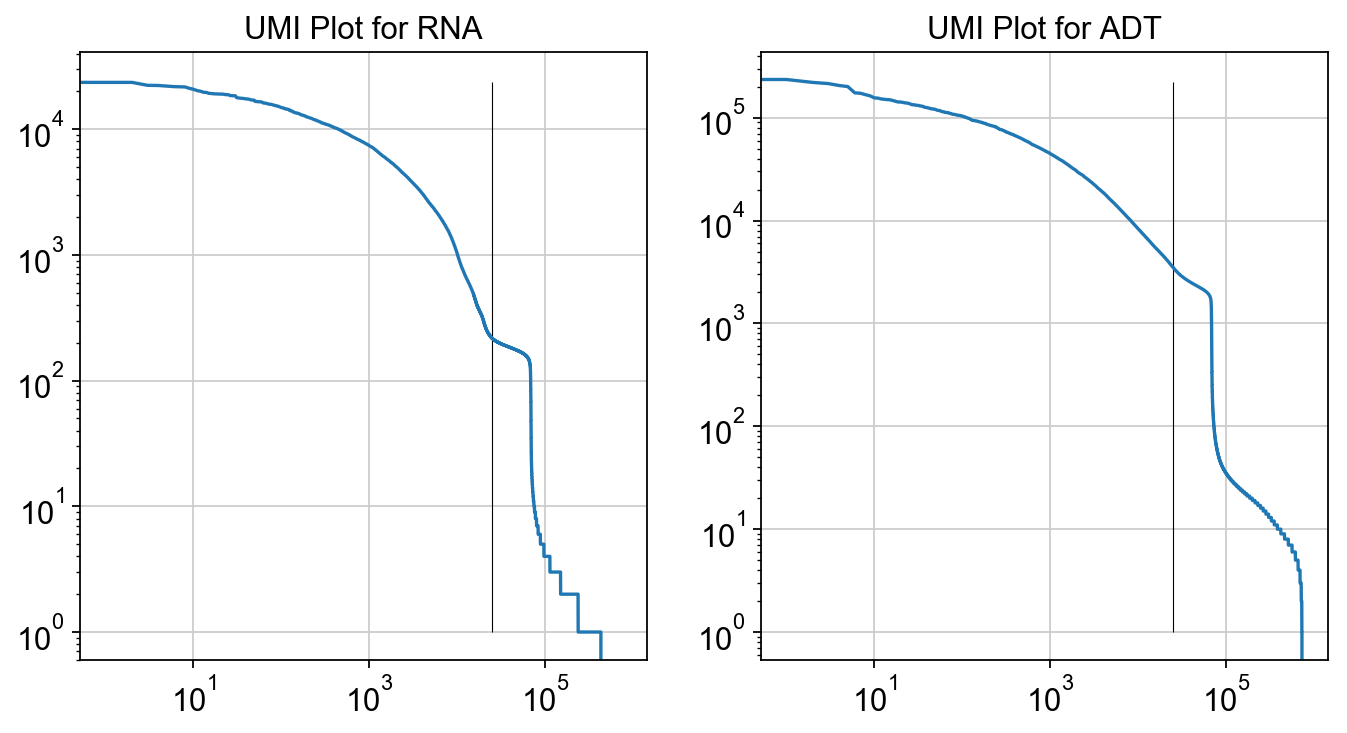

Forcing cells.
filtered out 3 cells that have more than  2500 genes expressed
Reading in files for 5_2.
reading 5_2-ADT.h5 (0:00:01.27)
reading 5_2-mRNA.h5 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(0:00:02.28)
Making UMI plots.


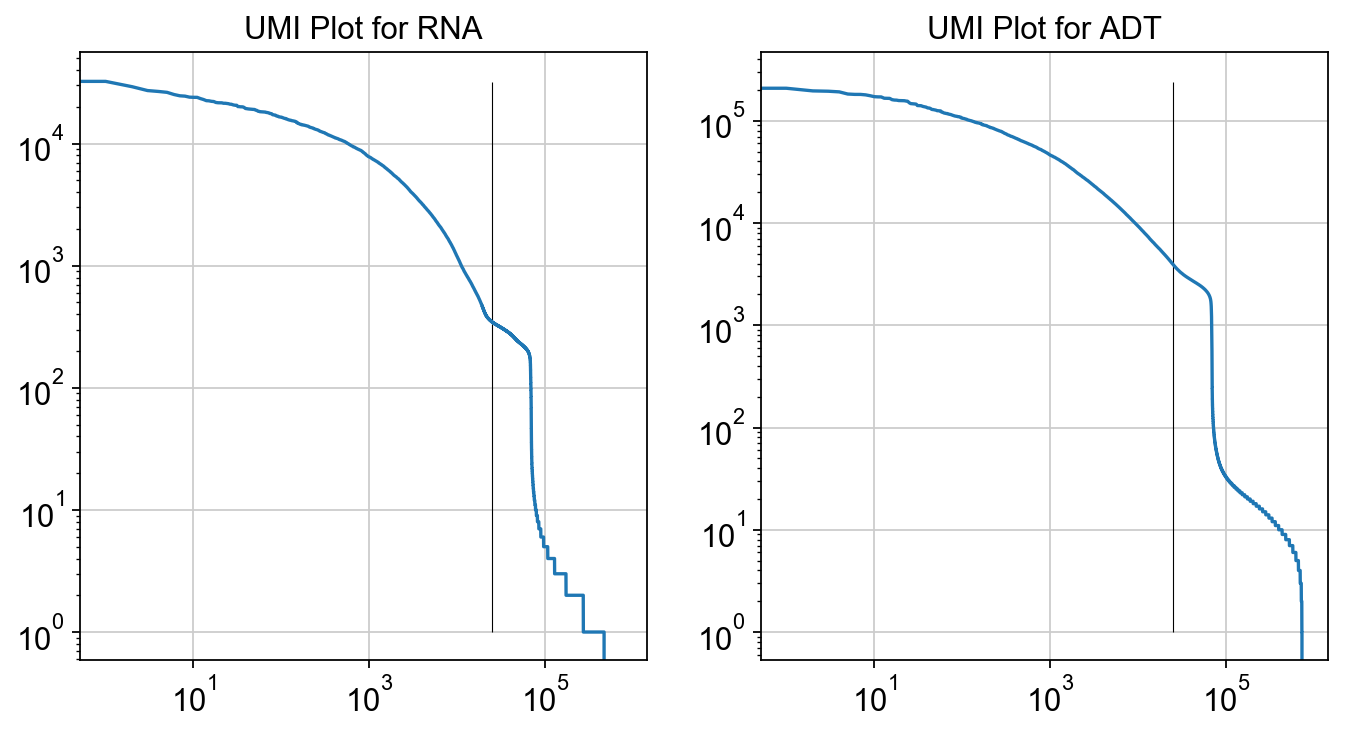

Forcing cells.
filtered out 1 cells that have more than  2500 genes expressed
Reading in files for 5_3.
reading 5_3-ADT.h5 (0:00:01.26)
reading 5_3-mRNA.h5 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(0:00:02.23)
Making UMI plots.


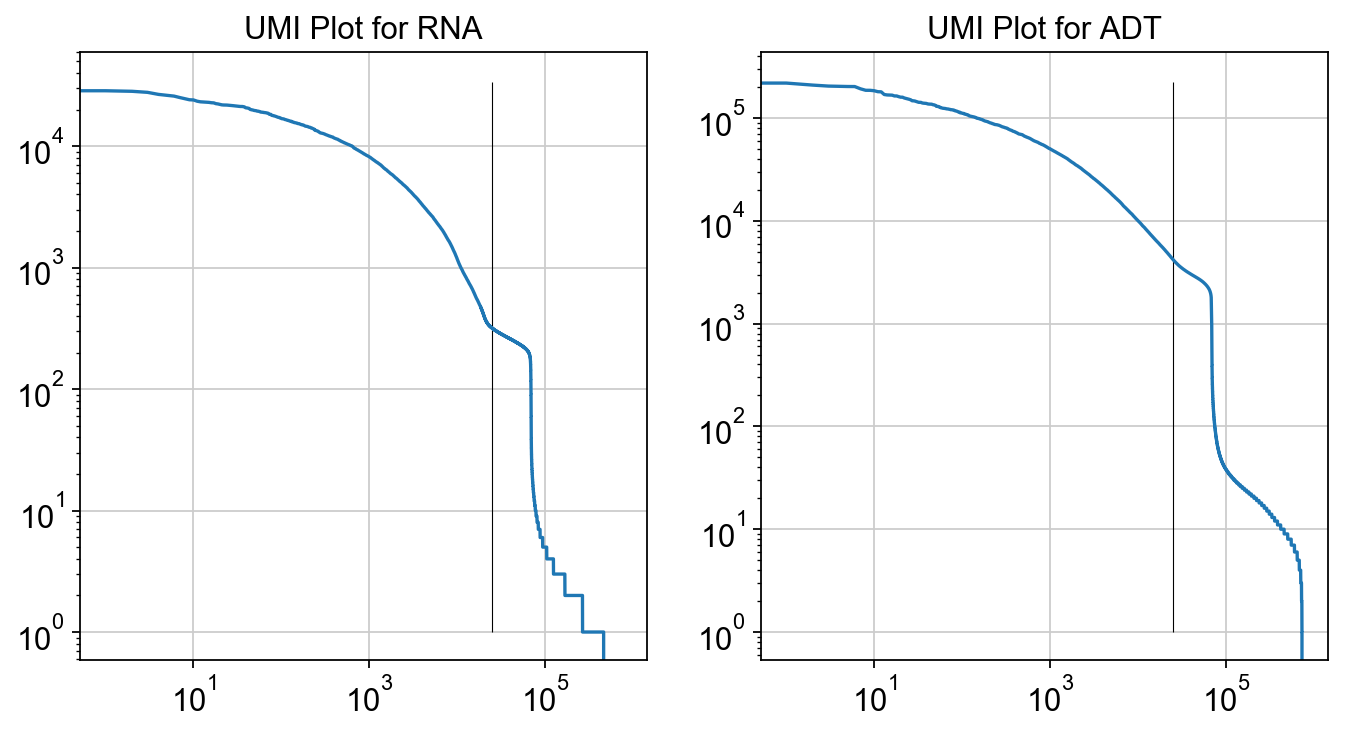

Forcing cells.
Reading in files for 5_4.
reading 5_4-ADT.h5 (0:00:01.34)
reading 5_4-mRNA.h5 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(0:00:02.19)
Making UMI plots.


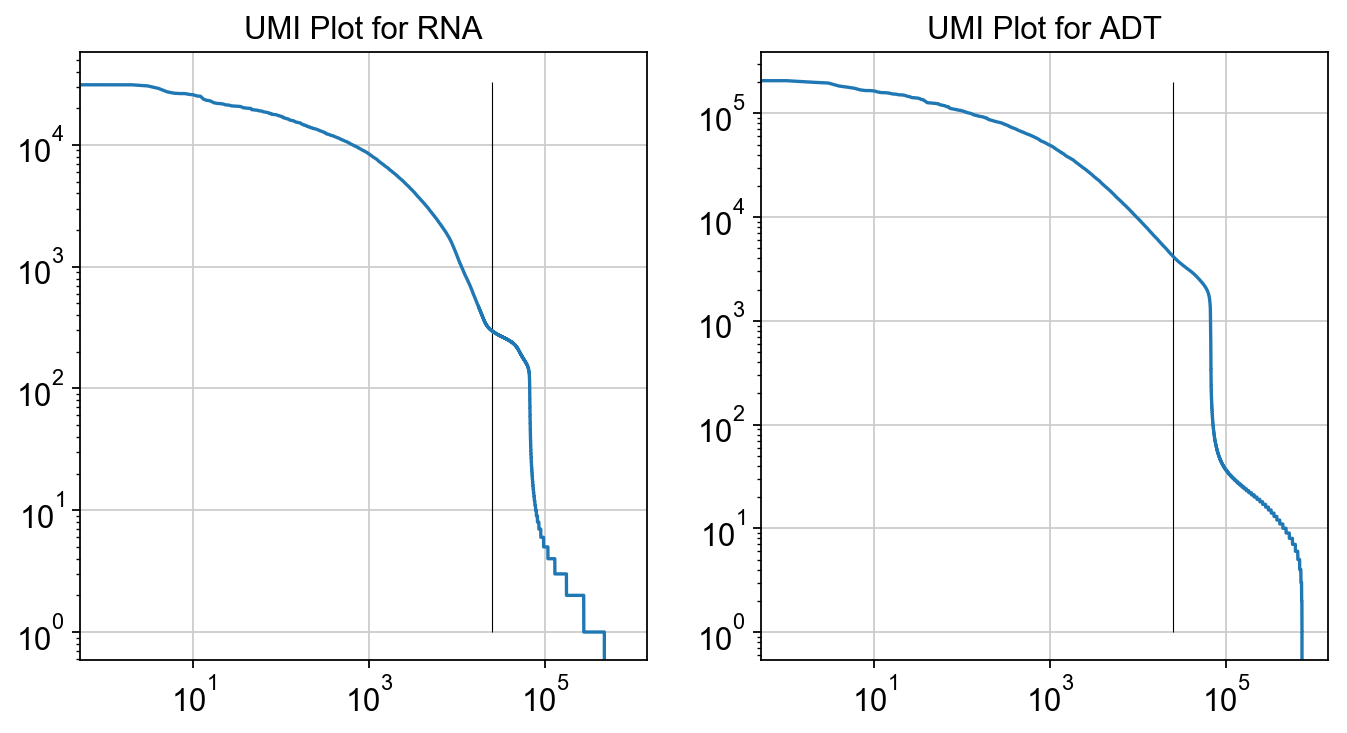

Forcing cells.
filtered out 1 cells that have more than  2500 genes expressed


In [4]:
run = '5'
cells = 25000
ADTs = list()
RNAs = list()

# This is specific for how I named the files
for run_well in ['_'.join(k) for k in zip([run]*4,[str(j) for j in range(1,5)])]:
    
    print('Reading in files for %s.' % run_well)
    ADT = sc.read_10x_h5(run_well + '-ADT.h5','BD99AbSeq')
    RNA = sc.read_10x_h5(run_well + '-mRNA.h5','GRCh38')
    RNA.var_names_make_unique()
    
    
    print('Making UMI plots.')
    umi_plot(RNA,ADT,cells)
    
    print('Forcing cells.')
    RNA = force_cells(cells,RNA)
    
    #  Process using a modified form of Richard's processing
    RNA = richard_process(RNA)
    
    # Take the intersection of barcodes
    intersection = set(RNA.obs.index.tolist()).intersection(set(ADT.obs.index.tolist()))
    ADT = ADT[[i in intersection for i in ADT.obs.index.tolist()]].copy()
    
    # Also record total ADT counts to regress this out later
    ADT.obs['n_counts'] = np.ravel(ADT.X.sum(axis=1))
    
    # Add both to a list of AnnData objects
    RNAs.append(RNA)
    ADTs.append(ADT)

Next, we'll combine all 4 wells into one AnnData object. It's nice becuase this automatically adds a batch number to `AnnData.obs` and also appends a smaller integer to the cell barcodes (just like `cellranger aggr` does, sort of).

In [5]:
RNAcomb = RNAs[0].concatenate(RNAs[1],RNAs[2],RNAs[3])
ADTcomb = ADTs[0].concatenate(ADTs[1],ADTs[2],ADTs[3])

At this point, it makes sense to me to first regress out the batch affects and then do further processing. However, Richard first does some further processing and then regresses out batch in his scripts. Upon trying to use the `sc.pp.regress_out()` function first, I get a divide by zero warning which leads to a "boundary condition" error (which is raised by the scipy statsmodel package, and not Scanpy). I'm sure there's just a few rows or columns which are causing this error, but I haven't tried to figure out which. Instead, I'll try the CLR normalization for both the RNA and the ADTs, and then find highly-variable genes (since it by default accepts log'ed data as input, which I would argue the CLR accomplishes), and then batch regress out. This is similar order of processing to Richard's scripts. If this doesn't work, I'll try the pipeline again with the standard logp1 normalization and the normalization per cell.  

In [6]:
RNAcomb.X = np.array(pd.DataFrame(RNAcomb.X.toarray() + 1,
                                  index=RNAcomb.obs_names,
                                  columns=RNAcomb.var_names).apply(lambda x: clr(x)))

ADTcomb.X = np.array(pd.DataFrame(ADTcomb.X.toarray() + 1,
                                  index=ADTcomb.obs_names,
                                  columns=ADTcomb.var_names).apply(lambda x: clr(x)))

In [7]:
RNAcomb = high_var_genes(RNAcomb)

In [8]:
RNAcomb

View of AnnData object with n_obs × n_vars = 15423 × 507 
    obs: 'percent_mito', 'n_counts', 'n_genes', 'batch'
    var: 'gene_ids-0', 'gene_ids-1', 'gene_ids-2', 'gene_ids-3'

Hmm, so even with forcing cells, it seems like after Richard's processing and filtering for highly-variable genes, it doesn't look like too many of the inputted cells or genes passed through anyway. Only  15,423 cells and 507 mRNA genes passed. In Flare runs 3 and 4, the number of mRNA genes passing filtering was around 1200, though I'd have to check back to see what the actual cell number was.

In [9]:
sc.pp.regress_out(RNAcomb,'batch')
sc.pp.regress_out(RNAcomb,['n_counts', 'percent_mito'])
sc.pp.regress_out(ADTcomb,'batch')
sc.pp.regress_out(ADTcomb,'n_counts')

regressing out batch
    finished (0:00:05.76)
regressing out ['n_counts', 'percent_mito']
    finished (0:00:04.02)
regressing out batch
    finished (0:00:00.82)
regressing out n_counts
    finished (0:00:00.69)


Now to build a combined AnnData object. Have to do some transposes because the native function doesn't allow for concatenating along the variables axis.

In [40]:
combann = RNAcomb.transpose().concatenate(ADTcomb.transpose(),index_unique=None).transpose()

In [43]:
combann

AnnData object with n_obs × n_vars = 15423 × 606 
    obs: 'percent_mito_RNA-0', 'n_counts_RNA-0', 'n_genes_RNA-0', 'batch_RNA-0', 'n_counts_ADT-1', 'batch_ADT-1'
    var: 'gene_ids-0', 'gene_ids-1', 'gene_ids-2', 'gene_ids-3', 'batch'

Now let's do some dim reduction. Using the "tSNE-like" parameters to louvain + UMAP. Note next cell yielded a divide by zero warning for me, but it still runs to completion. Also, as per default for high-D data, scanpy does a PCA first before find neighbors.

In [44]:
sc.pp.neighbors(combann,n_neighbors=30)
sc.tl.louvain(combann,)
sc.tl.umap(combann,min_dist=2,gamma=50)

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
    finished (0:00:09.23) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:02.99) --> found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
computing UMAP


/Users/student/UCSF/Ye_Lab/AbSeq-FLARE-wSasha/ADT_processing/AbFlare1_1/adt.processing/lib/python3.6/site-packages/scanpy/neighbors/umap/umap_.py:1173: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


    finished (0:00:12.22) --> added
    'X_umap', UMAP coordinates (adata.obsm)


... storing 'batch_RNA-0' as categorical
... storing 'batch_ADT-1' as categorical


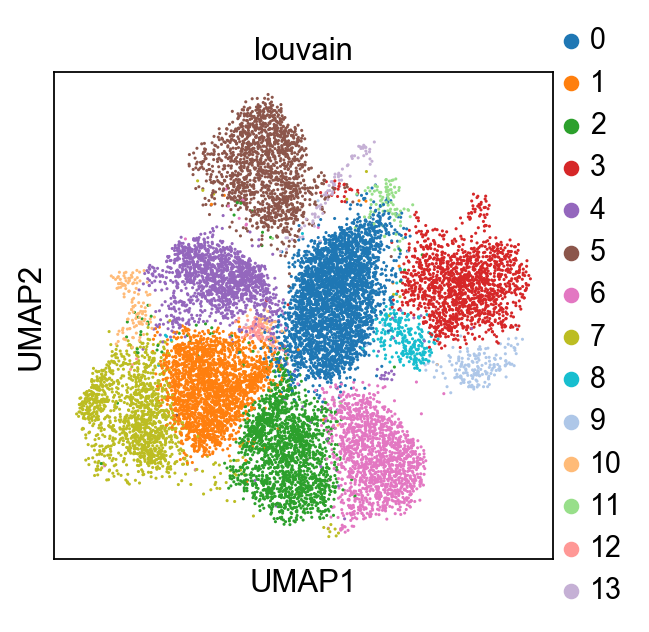

In [45]:
sc.pl.umap(combann,color='louvain')

This doesn't looks too bad. Let's see if we can find concordance between proteins and RNAs. Use and reuse the next cell to look up the exact name of the gene and or proteins. Genes are regular alphanumeric strings, proteins have a '|' character in them.

In [53]:
gene_or_protein_to_look_up = 'GNLY'
combann.var_names[combann.var_names.str.contains(gene_or_protein_to_look_up)]

Index(['GNLY'], dtype='object')

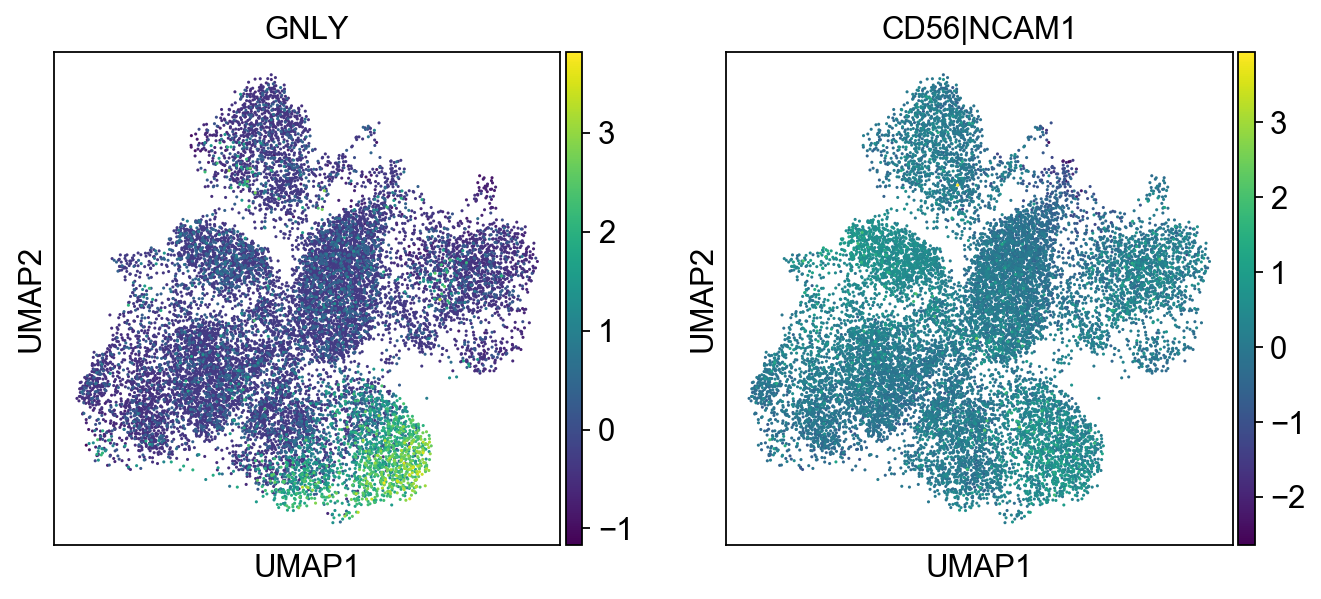

In [47]:
sc.pl.umap(combann,color=['GNLY','CD56|NCAM1'])

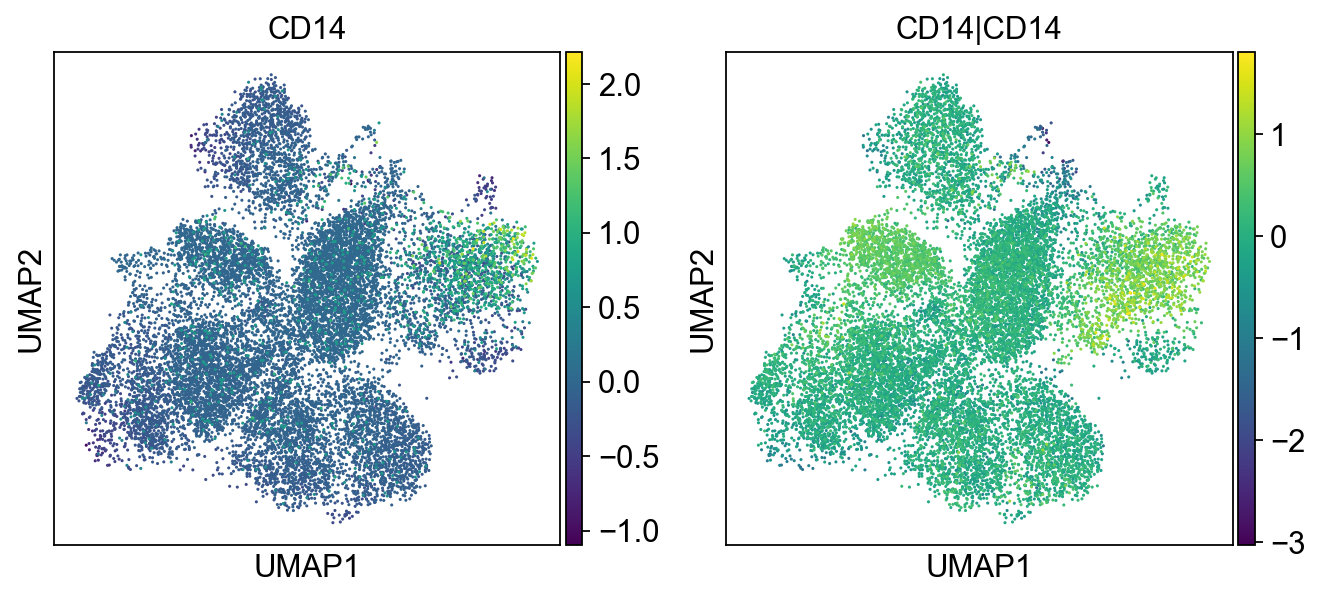

In [48]:
sc.pl.umap(combann,color=['CD14','CD14|CD14'])

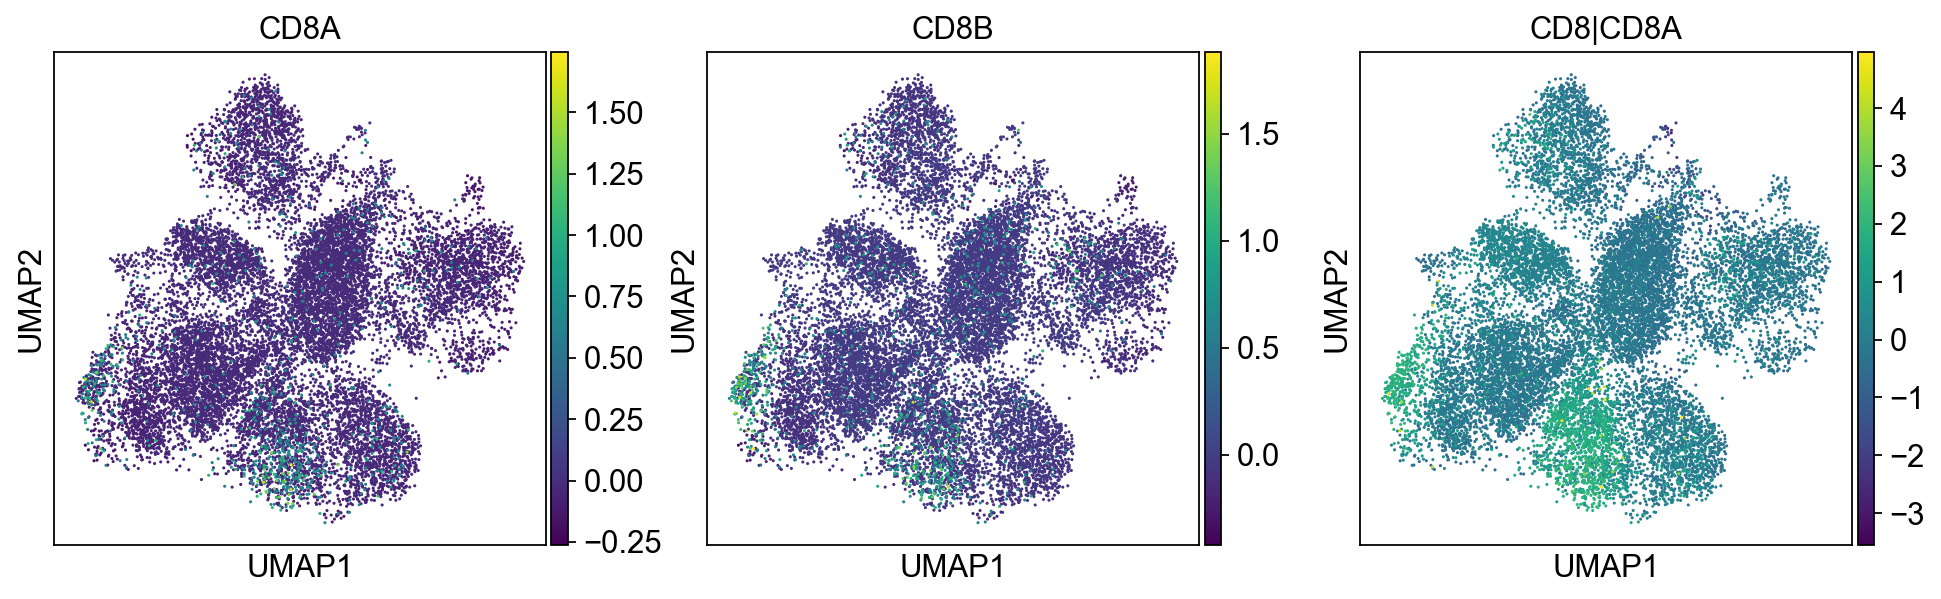

In [49]:
sc.pl.umap(combann,color=['CD8A','CD8B','CD8|CD8A'])

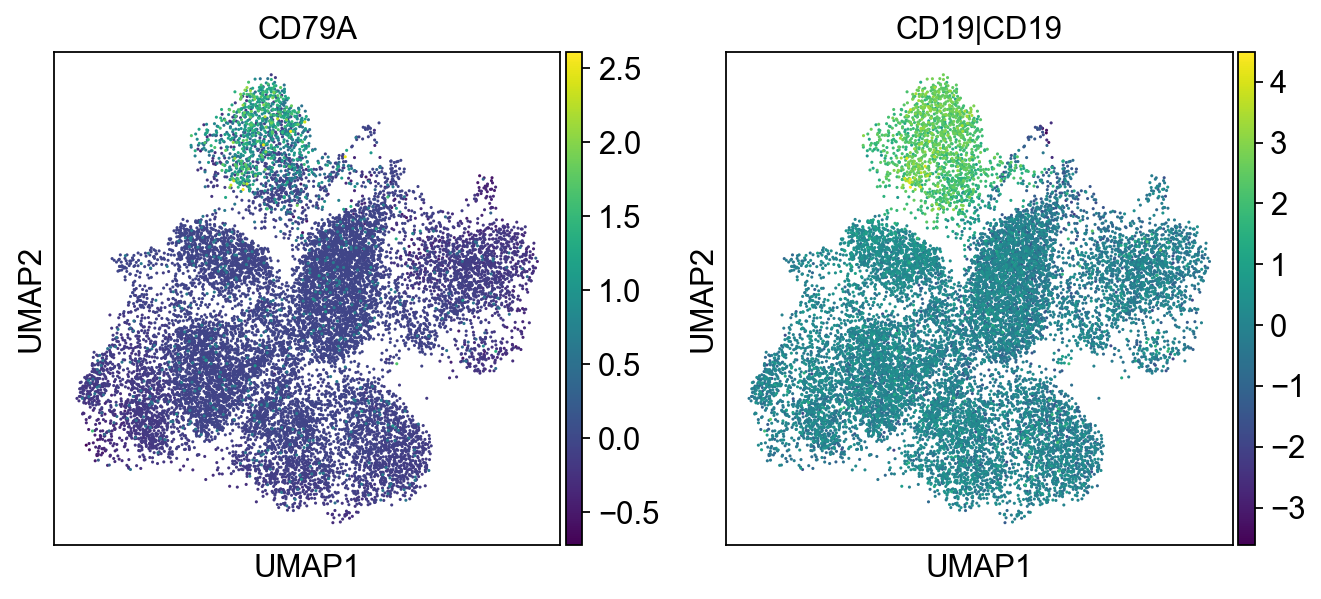

In [50]:
sc.pl.umap(combann,color=['CD79A', 'CD19|CD19'])

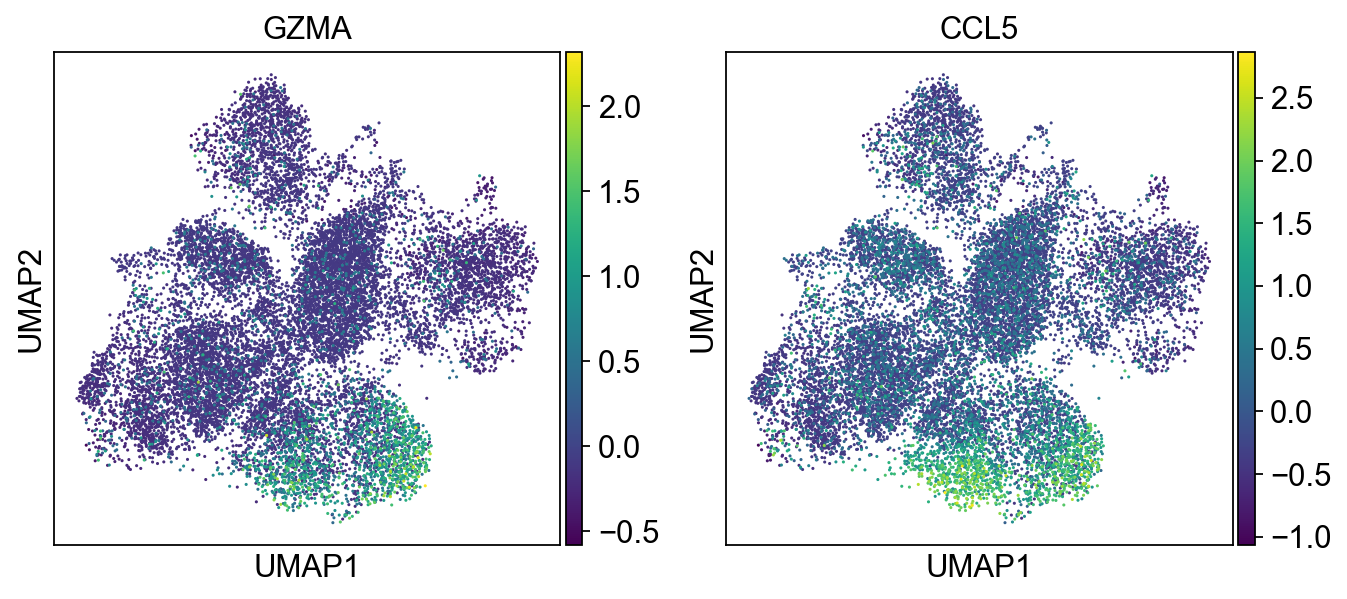

In [51]:
sc.pl.umap(combann,color=['GZMA', 'CCL5']) # these are two different RNAs

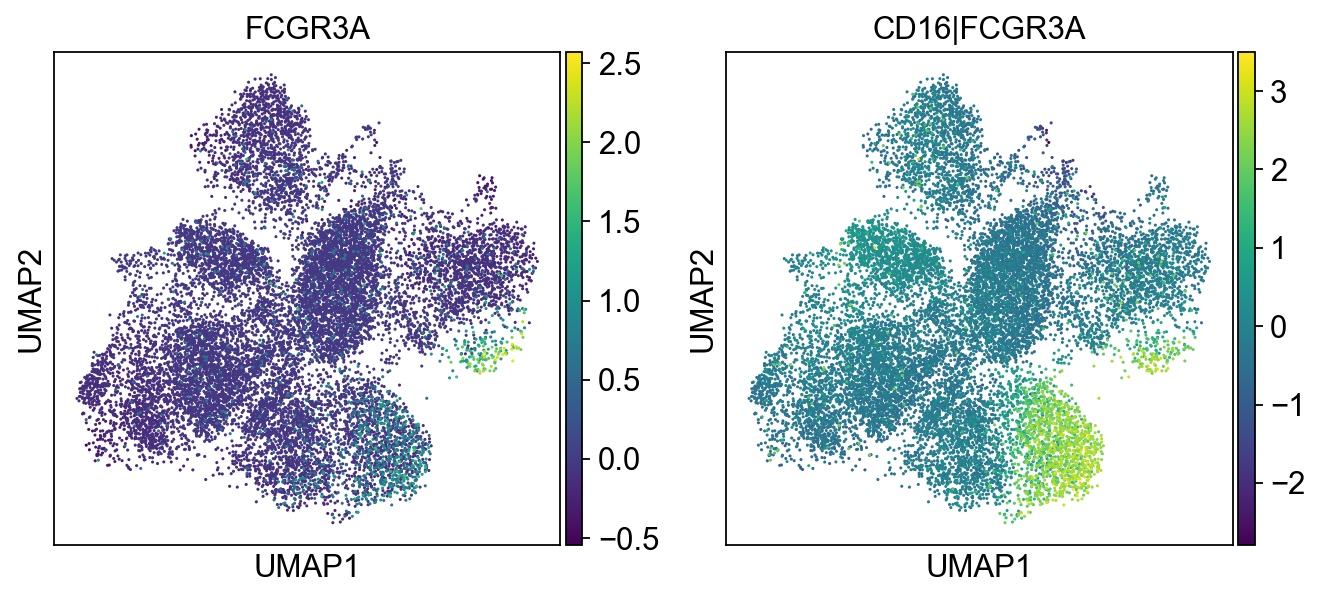

In [52]:
sc.pl.umap(combann,color=['FCGR3A', 'CD16|FCGR3A'])

These look nice! :) Some caveats: 
1. Doublets have not been removed (probably a large portion of these are doublets), and also these are _everyone's_ cells, and have not been separated by genotype yet.
2. There's still _significantly_ less cells than expected (15,000 vs. expected 100,000). I need to figure out at which point of Richard's processing the most cells are being removed. I wonder if we could relax some of the restrictions.

## Extras:

In [ ]:
# for renaming cell barcodes in 'cell aggr' fashion
for matlist in [RNAs,ADTs]:
    for j in range(1,len(matlist)+1):
        matlist[j-1].obs.index = ['-'.join([i.split('-')[0],str(j)]) for i in matlist[j-1].obs.index]